In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from scipy.stats import bernoulli, norm, norminvgauss
import imageio
np.random.seed(201)

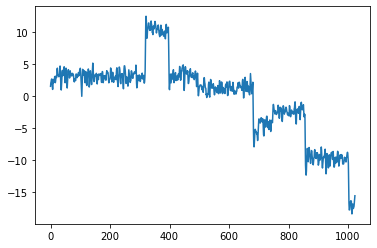

In [92]:
T =1024

big_shock = 4
med_shock = 2
small_shock = 1

def arma22(N, alpha, beta, rnd, eps=0.5):
    inov = rnd.rvs(2*N)
    x = np.zeros(2*N)

    # arma22 mode
    mean = 0.0
    for i in range(2,N*2):

        rnd = np.random.rand()
        sig = 1 if np.random.rand() > 0.5 else -1
        if(rnd > 0.997):
            mean += sig * big_shock
        elif(rnd > 0.995):
            mean += sig * med_shock
        elif(rnd > 0.990):
            mean += sig * small_shock
        # else do nothing

        x[i] = mean + (alpha[0] * x[i-1] + alpha[1]*x[i-2] + 
                    beta[0] * inov[i-1] + beta[1] * inov[i-2] + eps * inov[i])
    result = x[N:]
    return result - np.mean(result)

alpha = [0.95, -0.5]
beta = [0.4, 0.0]
eps = 0.1

series = arma22(T, alpha, beta, norm(1.0), eps=eps)
plt.plot(series)

In [210]:
from scipy.ndimage import gaussian_filter

#  FIXME make the spacing between scales logarithmic
scales = np.logspace(0, 3, 50)
# scales = np.arange(1, T//4, 2)
first_order = [gaussian_filter(series, i, 1, mode='reflect') for i in scales]
scale_space = [gaussian_filter(series, i, 2, mode='reflect') for i in scales]
saddle = [gaussian_filter(series, i, 3, mode='reflect') for i in scales]



In [214]:
scales

array([   1.        ,    1.1513954 ,    1.32571137,    1.52641797,
          1.75751062,    2.02358965,    2.32995181,    2.6826958 ,
          3.0888436 ,    3.55648031,    4.09491506,    4.71486636,
          5.42867544,    6.25055193,    7.19685673,    8.28642773,
          9.54095476,   10.98541142,   12.64855217,   14.56348478,
         16.76832937,   19.30697729,   22.22996483,   25.59547923,
         29.47051703,   33.93221772,   39.06939937,   44.98432669,
         51.79474679,   59.63623317,   68.6648845 ,   79.06043211,
         91.0298178 ,  104.81131342,  120.67926406,  138.94954944,
        159.98587196,  184.20699693,  212.09508879,  244.20530945,
        281.1768698 ,  323.74575428,  372.75937203,  429.19342601,
        494.17133613,  568.9866029 ,  655.12855686,  754.31200634,
        868.51137375, 1000.        ])

In [211]:
ss_img = np.vstack(scale_space).T
o1_img = np.vstack(first_order).T

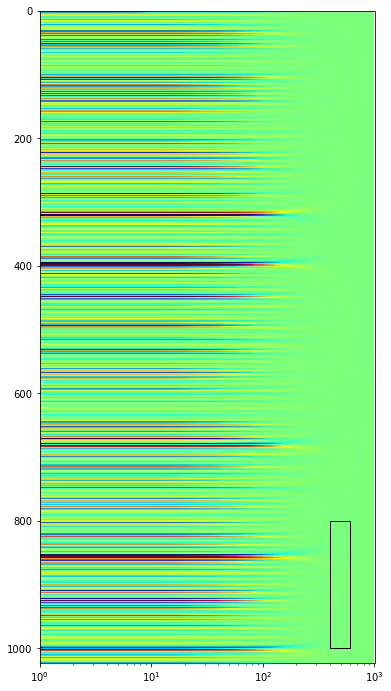

In [212]:
# from skimage import measure



# Find contours at a constant value of 0
contours = measure.find_contours(ss_img, 0)

# FIXME: this method finds contours in image space (using marching squares
# It doesn't see the log scale of the wavelets (rather the index of the pixel)
# might need to map the scale values to their log equivalents

# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(6,12))
tune = 1
pos = ax.imshow(ss_img, aspect='auto',vmin=-tune, vmax=tune, cmap='jet',
                extent=[scales[0],scales[-1],T-1,0], alpha=1.0)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    break
   
#ax.axis('image')
# ax.set_xticks([])
# ax.set_yticks([])
#fig.colorbar(pos)
ax.set_xscale('log')
from matplotlib.patches import Rectangle
rect = Rectangle((400, 800), 200, 200, linewidth=1, edgecolor='k', fill=False)
ax.add_patch(rect)

ax.set_xlim([scales[0], scales[-1]])
plt.show()



In [276]:
max_scales = []
top_locations = []
bottom_locations = []
contour_id = []

contour_list = []

for i, contour in enumerate(contours):
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=2
    
    max_scale = np.max(contour[:,1])
    locations = contour[contour[:,1]==0.][:,0]
    if len(locations) == 2:
        [location1, location2] = np.sort(locations)
    else:
        location1 = locations[0]
        location2 = None
        
#     print(f'Contour {i} top location: {location1}, bottom location: {location2}, max scale: {max_scale}')
    max_scales.append(max_scale)
    top_locations.append(location1)
    bottom_locations.append(location2)
    contour_id.append(i)
    
    contour_list.append({
        'max_scale': max_scale,
        'location1': location1,
        'location2': location2,
        'id': i,
        'data': contour
    })

df = pd.DataFrame({'contour_id': i, 'max_scale': max_scales, 'top_location': top_locations, 'bottom_location': bottom_locations})

contour_list = sorted(contour_list, key=lambda d: d['max_scale'], reverse=True)


In [277]:
class IntervalNode(object):
    def __init__(self, scale, top_edge, bottom_edge, contour):
        self.scale = scale
        self.top_edge = top_edge
        self.bottom_edge = bottom_edge
        self.contour = contour
        self.children = []
    
    def __str__(self):
        string = f"Interval scale: {self.scale:.1f} top: {self.top_edge:.1f}, bottom: {self.bottom_edge:.1f}, children: {self.children}"
        return string
    
    def __repr__(self):
        return f"Scale: {self.scale:.1f}[{self.top_edge:.1f},{self.bottom_edge:.1f}]"

    def add_child(self, obj):
        self.children.append(obj)

    def has_children(self):
        return len(self.children) > 0

    def get_children(self):
        return self.children
    
    def get_interval(self):
        return (self.top_edge, self.bottom_edge)
    
    def get_data(self):
        data = {'scale': self.scale, 'top': self.top_edge, 'bottom': self.bottom_edge}
        return data
        
    def contains(self, contour):
        is_in = False
#         print(contour['location1'])
#         print(f"countour loc1: {contour['location1']}, contour loc2: {contour['location2']}")
#         print(self)
        if (contour['location1'] > self.top_edge) & (contour['location1'] < self.bottom_edge):
#             print('location 1 is in!')
            if contour['location2']:
#                 print('location 2 is in!')
                if (contour['location2'] > self.top_edge) & (contour['location2'] < self.bottom_edge):
                    is_in = True
            else:
                is_in = True
        return is_in
    
    def preOrderTraversal(self, node):
        res = []
        if node:
            res.append(node.get_data())
            for child in node.get_children():
                res = res + node.preOrderTraversal(child)
        return res
                

# algo to traverse the tree, and find the parent interval (node) for each contour to be added
def get_parent_interval(node, contour):
    
    
    # if current node contains the contour, and has no children, then return current node
    if node.contains(contour) & ~node.has_children():
        return node
    
    elif node.contains(contour) & node.has_children(): # if current node contains the contour, but has children, then find the parent interaval among the children
        for child in node.get_children():
            parent_int = get_parent_interval(child, contour)
            if parent_int:
                return parent_int
    else:
        return None
    

In [290]:
root = IntervalNode(50, 0, 1023, None) # arbitrarily high root node
for i, contour in enumerate(contour_list):
#     child_node = IntervalNode(contour['max_scale'], contour['location1'], contour['location2'])
    print(f"Adding contour {i} with scale: {contour['max_scale']:.1f}, top: {contour['location1']:.1f}, bottom: {contour['location2'] if contour['location2'] else np.nan:.1f}")
    parent_node = get_parent_interval(root, contour)
    parent_top, parent_bottom = parent_node.get_interval()
    
    if contour['location2']:
        num_segments = 3
        first_segment = IntervalNode(contour['max_scale'], parent_top, contour['location1'], contour)
        second_segment = IntervalNode(contour['max_scale'], contour['location1'], contour['location2'], contour)
        third_segment = IntervalNode(contour['max_scale'], contour['location2'], parent_bottom, contour)
        parent_node.add_child(first_segment)
        parent_node.add_child(second_segment)
        parent_node.add_child(third_segment)
    else:
        num_segments = 2
        first_segment = IntervalNode(contour['max_scale'], parent_top, contour['location1'], contour)
        second_segment = IntervalNode(contour['max_scale'], contour['location1'], parent_bottom, contour)
        parent_node.add_child(first_segment)
        parent_node.add_child(second_segment)
    

Adding contour 0 with scale: 49.0, top: 856.0, bottom: nan
Adding contour 1 with scale: 39.2, top: 318.9, bottom: nan
Adding contour 2 with scale: 33.3, top: 397.5, bottom: 587.3
Adding contour 3 with scale: 31.7, top: 681.3, bottom: 747.2
Adding contour 4 with scale: 30.4, top: 21.3, bottom: 78.0
Adding contour 5 with scale: 27.6, top: 940.8, bottom: 1001.9
Adding contour 6 with scale: 25.8, top: 140.0, bottom: 204.7
Adding contour 7 with scale: 25.0, top: 432.7, bottom: 495.5
Adding contour 8 with scale: 22.1, top: 614.9, bottom: 626.5
Adding contour 9 with scale: 22.1, top: 143.8, bottom: 187.4
Adding contour 10 with scale: 21.1, top: 221.2, bottom: 251.9
Adding contour 11 with scale: 19.8, top: 793.7, bottom: 819.5
Adding contour 12 with scale: 19.7, top: 536.5, bottom: 549.1
Adding contour 13 with scale: 19.4, top: 85.1, bottom: 102.8
Adding contour 14 with scale: 19.4, top: 270.5, bottom: 288.6
Adding contour 15 with scale: 19.1, top: 886.2, bottom: 924.5
Adding contour 16 with s

In [291]:
root.get_data()

{'scale': 50, 'top': 0, 'bottom': 1023}

In [292]:
rect_list = root.preOrderTraversal(root)
# rect him?!? damn near killed him!

In [293]:
len(rect_list)

503

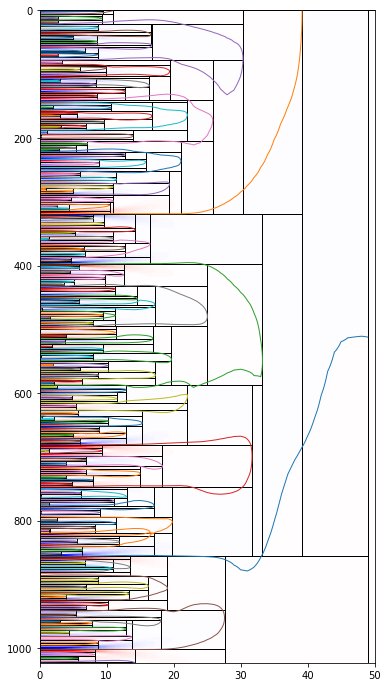

In [300]:
# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(6,12))
tune = 1
# pos = ax.imshow(ss_img, aspect='auto',vmin=-tune, vmax=tune, cmap='jet',
#                 extent=[scales[0],scales[-1],T-1,0], alpha=1.0)
pos = ax.imshow(ss_img, aspect='auto',vmin=-tune, vmax=tune, cmap='seismic', 
                extent=[0,50,T-1,0],alpha=1)
 

for i, contour in enumerate(contour_list):

    ax.plot(contour['data'][:, 1], contour['data'][:, 0], linewidth=1, alpha=1)

   
#ax.axis('image')
# ax.set_xticks([])
# ax.set_yticks([])
#fig.colorbar(pos)
# ax.set_xscale('log')
# ax.set_xlim([scales[0], scales[-1]])
# ax.set_xlim([-10, 53])
# ax.set_ylim([64,0])

for i, rect in enumerate(rect_list):
    bottom = rect['bottom']
    top = rect['top']
    scale = rect['scale']
#     print(f"scale: {scale}, top: {top}, bottom: {bottom}")
    rect = Rectangle((0, top), scale, bottom-top, linewidth=1, edgecolor='k', fill=False)
    ax.add_patch(rect)


plt.show()
# fig.savefig("images/ternery_tessellation.png", bbox_inches="tight")


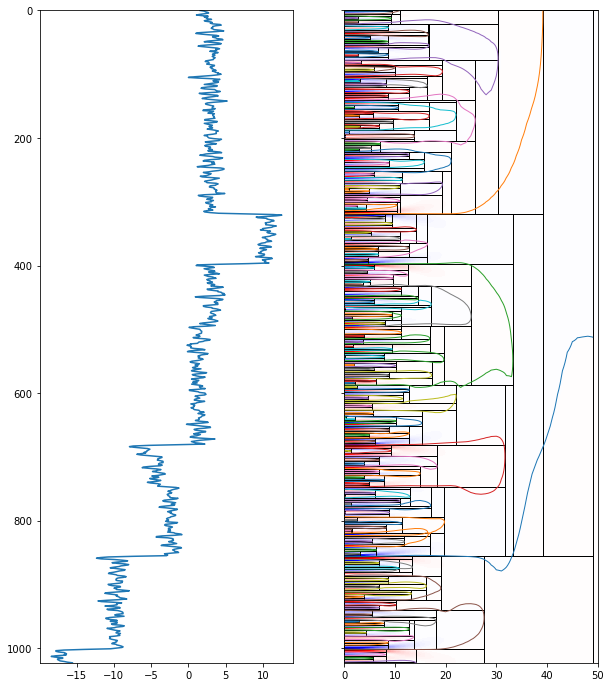

In [302]:
# Display the image and plot all contours found
fig, ax = plt.subplots(1,2,figsize=(10,12), sharey=True)
tune = 1

ax[0].plot(series, np.arange(len(series)))


pos = ax[1].imshow(ss_img, aspect='auto',vmin=-tune, vmax=tune, cmap='seismic', 
                extent=[0,50,T-1,0],alpha=1)
 
for i, contour in enumerate(contour_list):
    ax[1].plot(contour['data'][:, 1], contour['data'][:, 0], linewidth=1, alpha=1)

for i, rect in enumerate(rect_list):
    bottom = rect['bottom']
    top = rect['top']
    scale = rect['scale']
    rect = Rectangle((0, top), scale, bottom-top, linewidth=1, edgecolor='k', fill=False)
    ax[1].add_patch(rect)


plt.show()

In [303]:
root.get_children()

[Scale: 49.0[0.0,856.0], Scale: 49.0[856.0,1023.0]]

[]

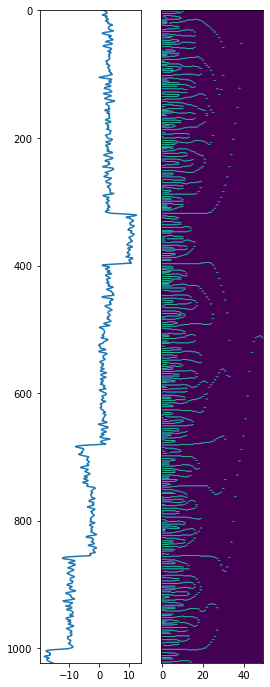

In [304]:
def find_zeros(scal, saddl):
    return np.logical_and(np.sign(scal[1:]) != np.sign(scal[:-1]),
            np.logical_not( np.sign(saddl[1:]) != np.sign(saddl[:-1]) ))

edges = np.vstack([find_zeros(*i) for i in zip(scale_space, saddle)]).T
saddle = np.vstack(saddle).T
scale_space = np.vstack(scale_space).T

fig, ax = plt.subplots(1,2,figsize=(4,12))

ax[1].imshow(edges, aspect='auto')
ax[0].plot(series, np.arange(len(series)))
ax[0].set_ylim([T-1,0])
ax[1].set_yticks([])

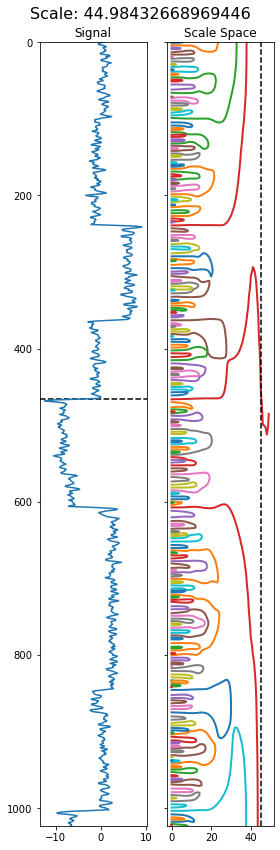

In [30]:
MAX_SCALE = 20

plot_scales = scales[scales < np.array(max_scales).max()]
filenames = []

for scale in np.flip(plot_scales):
    fig, ax = plt.subplots(1,2,figsize=(4,12), sharey=True)
    ax[0].set_title('Signal')
    ax[1].set_title('Scale Space')
    plt.suptitle(f"Scale: {scale}", fontsize=16)
    for contour in contours:
    #     ax.plot(contour[:, 1], contour[:, 0], linewidth=2

        max_scale = np.max(contour[:,1])
        locations = contour[contour[:,1]==0.][:,0]
        if len(locations) == 2:
            [location1, location2] = np.sort(locations)
        else:
            location1 = locations[0]
            location2 = None
        if max_scale >= scale:
            ax[0].axhline(location1,c='k',linestyle='--')
            if location2:
                ax[0].axhline(location2,c='k',linestyle='--')

        ax[1].plot(contour[:, 1], contour[:, 0], linewidth=2)
    # ax[1].set_aspect([.1, 1])
    ax[1].axvline(scale, c='k', linestyle='--')
    # pos = ax[1].imshow(ss_img, aspect='auto',vmin=-tune, vmax=tune, cmap='jet',
    #             extent=[scales[0],scales[-1],T-1,0])
    # ax[1].set_xscale('log')
    # ax[1].set_xlim([scales[0], scales[-1]])
    ax[0].plot(series, np.arange(len(series)))

    ax[0].set_ylim([T-1,0])
    # ax[1].set_xscale('log')
    plt.tight_layout()
    
    filename = f"scale{scale}.png"
#     fig.savefig(filename, bbox_inches="tight",facecolor="white")
    filenames.append(filename)
#     plt.close()
    
    break
    # ax[1].set_yticks([])

In [37]:
# Build GIF
with imageio.get_writer('log_scale.gif', mode='I', duration=0.2) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

(1023.0, 0.0)

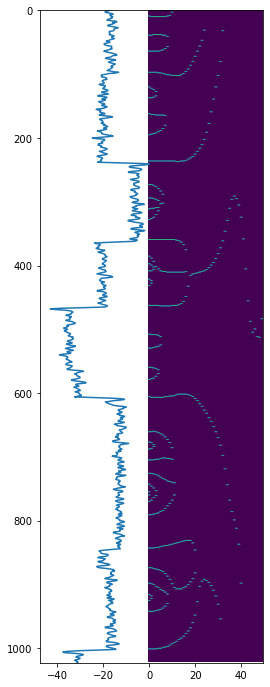

In [31]:
fig, ax = plt.subplots(figsize=(4,12))

ax.imshow(edges, aspect='auto')
ax.plot( 2*(series - np.max(series)), np.arange(len(series)))
ax.set_ylim([T-1,0])

In [32]:
#  Concept (Based on Witkin's paper) for tracking the contours:
#  1. none of the contours should intersect.
#  2. a feature at a larger scale is visible at all smaller scales.
#  Suppose we start at the coarsest scale and find all the zeros, this 
#  will define. Boundary conditions are that there is always an
#  edge at the boundary

# Boundary conditions
edges[0, :] = True
edges[-1, :] = True


In [6]:
contours = list(enumerate(np.where(edges[:,-1])[0].tolist()))
print(contours)
contours = list(enumerate(np.where(edges[:,-26])[0].tolist()))
print(contours)

[(0, 0), (1, 322), (2, 757), (3, 1022)]
[(0, 0), (1, 13), (2, 361), (3, 701), (4, 1022)]


In [25]:
# because there isn't a new contour, and that the contours don't cross, we
# therefore know that the contour labels can just be based on the previous sequence
# 0, 1, 2, 3 in this case
contours = list(enumerate(np.where(edges[:,-25])[0].tolist()))
contours

[(0, 0), (1, 360), (2, 703), (3, 1022)]

In [29]:
# An extra change point appeared! Which one is new?
contours = list(enumerate(np.where(edges[:,-26])[0].tolist()))
contours

[(0, 0), (1, 13), (2, 361), (3, 701), (4, 1022)]

In [42]:
# We've got an extra contour, which of the zeros gets the new label(s)
def test_new(x):
    return not np.any(x)

def window(series, i, j):
    # FIXME should take the bounds between previous/next edge
    return series[max(i-10, 0):min(i+10, T-1), j]

[(i[1], test_new(window(edges, i[1], -25))) for i in contours[1:-1]]
# 1. Because the contours don't cross, we know that the
# one(s) that don't have a change point with the previous scale
# are new. So they get a new label, the other ones get labeled 
# with the previous contour labels.


[(13, True), (361, False), (701, False)]